In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Suzuki.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Alto,Seri_Baleno,Seri_Maruti,...,Model_1.3 MT 4X4,Model_1.5 AT,Model_1.6,Model_1.6 GLX,Model_800,Model_GL,Yakıt Tipi_Benzin,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik
0,379500,2013,122,1586,194000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1,364000,2011,93,1328,123000,NaN,NaN,0,0,0,...,1,0,0,0,0,0,1,0,1,0
2,415000,2011,95,1242,77000,5.0,3.0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,140000,1993,53,993,105000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,275000,2007,93,1328,277000,11.0,1.0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_10328\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,46015.743396,2.203921e+09,46945.932301,36871.537946


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:24:15,302] A new study created in memory with name: no-name-27ce3f9d-cf95-4ad4-8d6e-317451de63e2
[I 2023-10-08 14:24:15,380] Trial 1 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.10112138556979394, 'max_depth': 15, 'min_child_weight': 215}. Best is trial 1 with value: 311268.37722494395.
[I 2023-10-08 14:24:15,380] Trial 0 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.16847225146892725, 'max_depth': 9, 'min_child_weight': 228}. Best is trial 1 with value: 311268.37722494395.
[I 2023-10-08 14:24:15,380] Trial 5 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.010088228781962402, 'max_depth': 6, 'min_child_weight': 199}. Best is trial 1 with value: 311268.37722494395.
[I 2023-10-08 14:24:15,380] Trial 3 finished with value: 311268.37722494395 and parameters: 

[I 2023-10-08 14:24:16,183] Trial 30 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.22751470373996838, 'max_depth': 12, 'min_child_weight': 63}. Best is trial 17 with value: 58285.25969541802.
[I 2023-10-08 14:24:16,217] Trial 31 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.22459998283909338, 'max_depth': 12, 'min_child_weight': 84}. Best is trial 17 with value: 58285.25969541802.
[I 2023-10-08 14:24:16,313] Trial 32 finished with value: 178838.2158242472 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.2109258600608999, 'max_depth': 8, 'min_child_weight': 47}. Best is trial 17 with value: 58285.25969541802.
[I 2023-10-08 14:24:16,340] Trial 34 finished with value: 179291.36740911027 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.2004213621907554, 'max_depth': 8, 'min_child_weight'

[I 2023-10-08 14:24:17,397] Trial 61 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.4901038018272274, 'max_depth': 14, 'min_child_weight': 199}. Best is trial 48 with value: 54789.97417400823.
[I 2023-10-08 14:24:17,397] Trial 60 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4995537767235196, 'max_depth': 14, 'min_child_weight': 220}. Best is trial 48 with value: 54789.97417400823.
[I 2023-10-08 14:24:17,397] Trial 62 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.49281794362370146, 'max_depth': 14, 'min_child_weight': 171}. Best is trial 48 with value: 54789.97417400823.
[I 2023-10-08 14:24:17,410] Trial 63 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2856704988975932, 'max_depth': 14, 'min_child_we

[I 2023-10-08 14:24:18,577] Trial 90 finished with value: 101868.32052117251 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.3969568369030885, 'max_depth': 13, 'min_child_weight': 25}. Best is trial 48 with value: 54789.97417400823.
[I 2023-10-08 14:24:18,683] Trial 91 finished with value: 102977.7068211489 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.3611859017461506, 'max_depth': 13, 'min_child_weight': 28}. Best is trial 48 with value: 54789.97417400823.
[I 2023-10-08 14:24:18,721] Trial 92 finished with value: 100755.20092945803 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.41125053024325686, 'max_depth': 13, 'min_child_weight': 27}. Best is trial 48 with value: 54789.97417400823.
[I 2023-10-08 14:24:18,751] Trial 93 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.39266687572643716, 'max_depth': 13, 'min_child_weigh

[I 2023-10-08 14:24:19,993] Trial 121 finished with value: 90750.50264707144 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3378082768419554, 'max_depth': 10, 'min_child_weight': 17}. Best is trial 113 with value: 54394.49088555565.
[I 2023-10-08 14:24:20,008] Trial 120 finished with value: 81121.39483033589 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.36966513005305407, 'max_depth': 10, 'min_child_weight': 15}. Best is trial 113 with value: 54394.49088555565.
[I 2023-10-08 14:24:20,013] Trial 122 finished with value: 91877.67583450698 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.32347560690251603, 'max_depth': 10, 'min_child_weight': 15}. Best is trial 113 with value: 54394.49088555565.
[I 2023-10-08 14:24:20,112] Trial 123 finished with value: 84311.8238746557 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3502858227655262, 'max_depth': 10, 'min_child_we

[I 2023-10-08 14:24:21,397] Trial 150 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.30433092880773155, 'max_depth': 7, 'min_child_weight': 85}. Best is trial 113 with value: 54394.49088555565.
[I 2023-10-08 14:24:21,437] Trial 151 finished with value: 87278.04096510181 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.29266142368855147, 'max_depth': 8, 'min_child_weight': 11}. Best is trial 113 with value: 54394.49088555565.
[I 2023-10-08 14:24:21,511] Trial 152 finished with value: 86736.74443345283 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.2836354759483786, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 113 with value: 54394.49088555565.
[I 2023-10-08 14:24:21,511] Trial 153 finished with value: 79150.5930106977 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.3834578579964317, 'max_depth': 8, 'min_child_weigh

[I 2023-10-08 14:24:22,933] Trial 180 finished with value: 52603.672557355 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.3978798304795354, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 180 with value: 52603.672557355.
[I 2023-10-08 14:24:23,005] Trial 181 finished with value: 277548.36759413884 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.0150241287990729, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 180 with value: 52603.672557355.
[I 2023-10-08 14:24:23,067] Trial 182 finished with value: 76564.86437013902 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.24873020322743988, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 180 with value: 52603.672557355.
[I 2023-10-08 14:24:23,099] Trial 183 finished with value: 53348.596147584736 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.4100409684598975, 'max_depth': 7, 'min_child_weight': 1}. B

[I 2023-10-08 14:24:24,487] Trial 207 finished with value: 238144.1170374179 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.035197434704914314, 'max_depth': 7, 'min_child_weight': 8}. Best is trial 180 with value: 52603.672557355.
[I 2023-10-08 14:24:24,608] Trial 211 finished with value: 67931.00976262863 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4941602094772503, 'max_depth': 7, 'min_child_weight': 8}. Best is trial 180 with value: 52603.672557355.
[I 2023-10-08 14:24:24,647] Trial 212 finished with value: 72429.58701619304 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.36642735580886254, 'max_depth': 7, 'min_child_weight': 8}. Best is trial 180 with value: 52603.672557355.
[I 2023-10-08 14:24:24,782] Trial 213 finished with value: 59258.768079192836 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.3723369188042207, 'max_depth': 6, 'min_child_weight': 1}.

[I 2023-10-08 14:24:26,285] Trial 239 finished with value: 58602.08728633985 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.33304239126804036, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 180 with value: 52603.672557355.
[I 2023-10-08 14:24:26,343] Trial 242 finished with value: 55580.23864305706 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3244873509610935, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 180 with value: 52603.672557355.
[I 2023-10-08 14:24:26,354] Trial 241 finished with value: 55302.215701527915 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3277355817200041, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 180 with value: 52603.672557355.
[I 2023-10-08 14:24:26,475] Trial 243 finished with value: 94639.10058178885 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3288861706743563, 'max_depth': 15, 'min_child_weight': 17}.

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 52603.6726
Best params:
	colsample_bytree: 0.8
	subsample: 0.7
	learning_rate: 0.3978798304795354
	max_depth: 15
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 45165.59522765267, 'MSE': 2220609281.8289394, 'RMSE': 47123.34115731756, 'MAE': 33262.400669642855}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9305652374110865

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8792438911497157

In [16]:
marka_model = joblib.dump(final_model, "Suzuki.pkl")

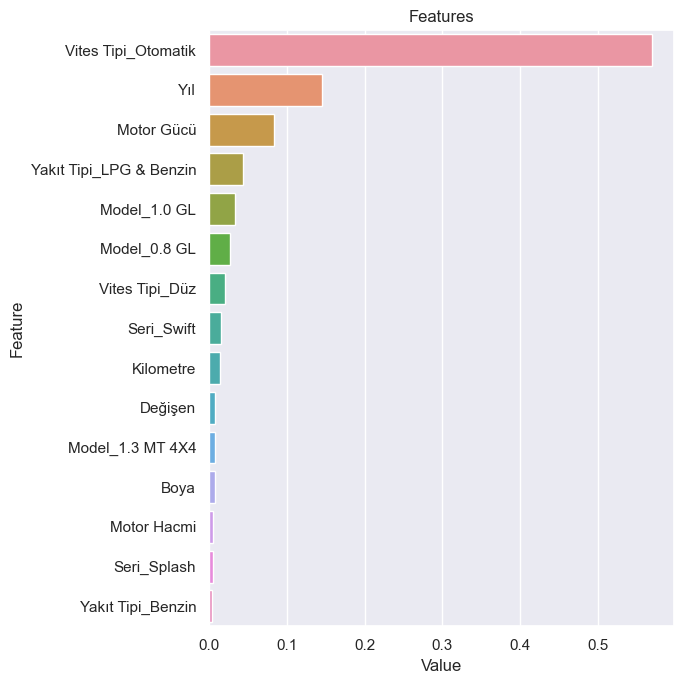

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)